#  Fit Neff

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : February 7th 2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
from datetime import datetime,date

In [30]:
from astropy import units as u
from astropy.coordinates import Angle

In [5]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [6]:
string_date

'2022-02-07'

In [7]:
from iminuit import Minuit
import iminuit

In [8]:
iminuit.__version__

'2.7.0'

In [9]:
from time import sleep

In [10]:
from astropy.time import Time
import astropy.units as u

# Config

In [11]:
DATE="2021-07-07"
DATE2="2021_07_07"

In [23]:
DCCD   = 181.45 # mm
PIXELW = 0.01   # mm (10 microns)

### Wide and narrow scan

In [12]:
file_csv="narrowwidescan_2021-07-07.csv"
file_xlsx="narrowwidescan_2021-07-07.xlsx"

In [21]:
df= pd.read_csv(file_csv, index_col=0)

In [22]:
df

,X(mm),Y(mm),degré,tag,Xpix,Neff,FlagGood,NarrowScan,wl_halpha,wl_o2,Xpix0,Ypix0,Xpix_halpha,Ypix_halpha,Xpix_o2,Ypix_o2
0,-6.834332,13.536706,0.304839,248,1353.670602,157.356972,True,False,656.433533,762.904358,1316.566809,681.329398,998.0,194.781104,1302.0,196.462393
1,-5.879631,12.273796,0.287949,249,1227.379635,157.473318,True,False,655.277649,764.469604,1412.036908,807.620365,1000.0,192.529519,1312.0,194.225394
2,-16.641820,1.325806,0.162526,250,132.580559,156.939617,True,False,656.279419,763.033386,335.818025,1902.419441,1002.0,189.400261,1306.0,190.218351
3,-16.236803,1.326900,0.193625,251,132.690005,157.370956,True,False,656.558716,763.020081,376.319657,1902.309995,1002.0,188.272972,1306.0,189.190892
4,-16.358922,1.439759,0.175763,252,143.975923,157.865249,True,False,656.375610,763.201843,364.107844,1891.024077,1002.0,188.444617,1308.0,189.337364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-18.921111,2.113223,-0.179557,345,211.322273,158.077496,True,True,656.329956,763.012756,107.888852,1823.677727,1002.0,171.129618,1308.0,170.565250
60,-18.938706,1.126771,-0.174666,346,112.677052,157.029486,True,True,656.437256,763.130127,106.129419,1922.322948,1002.0,175.935336,1306.0,175.433712
61,-18.865694,0.111250,-0.175392,347,11.125003,157.065247,True,True,656.377991,763.046570,113.430571,2023.874997,1002.0,173.628356,1306.0,173.105217
62,-18.874612,-0.863775,-0.176366,348,-86.377457,158.596029,True,True,656.125854,763.154846,112.538836,2121.377457,1002.0,174.560424,1310.0,174.022098


# Select one spectrum

In [24]:
index=0

In [27]:
row = df.iloc[index]

In [29]:
row

X(mm)            -6.834332
Y(mm)            13.536706
degré             0.304839
tag                    248
Xpix           1353.670602
Neff            157.356972
FlagGood              True
NarrowScan           False
wl_halpha       656.433533
wl_o2           762.904358
Xpix0          1316.566809
Ypix0           681.329398
Xpix_halpha          998.0
Ypix_halpha     194.781104
Xpix_o2             1302.0
Ypix_o2         196.462393
Name: 0, dtype: object

In [44]:
X0=row["Xpix0"]
X1=row["Xpix_halpha"]
Y1=row["Ypix_halpha"]

X2=row["Xpix_o2"]
Y2=row["Ypix_o2"]

WL1=row["wl_halpha"]
WL2=row["wl_o2"]

alpha= Angle(row["degré"],u.degree).radian

998.0

In [46]:
def Chi2(Neff):
    
    lambda1_neff = WL1*Neff*1e-6 #mm
    lambda2_neff = WL2*Neff*1e-6 #mm
    
    chi2= (X1*PIXELW - np.cos(alpha)*DCCD*lambda1_neff/np.sqrt(1-lambda1_neff**2))**2+ \
    (Y1*PIXELW - np.sin(alpha)*DCCD*lambda1_neff/np.sqrt(1-lambda1_neff**2))**2+ \
     (X2*PIXELW - np.cos(alpha)*DCCD*lambda2_neff/np.sqrt(1-lambda2_neff**2))**2+ \
    (Y2*PIXELW - np.sin(alpha)*DCCD*lambda2_neff/np.sqrt(1-lambda2_neff**2))**2
    
    return chi2
    
    

In [49]:
all_neff = np.linspace(0,1000)

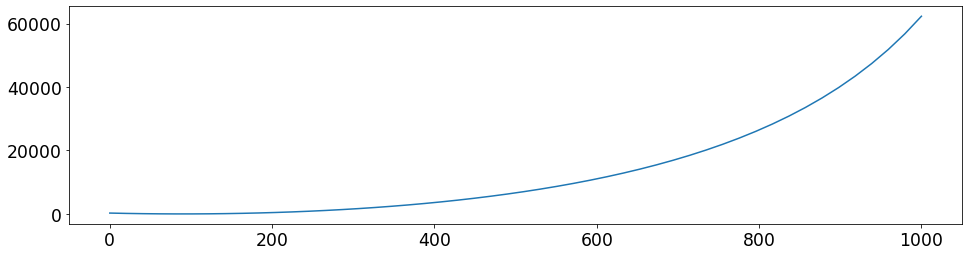

In [50]:
plt.plot(all_neff,Chi2(all_neff))